# Easy use

This file allows you to use the entire software package yourself, with minimal programming!

First we convert the necessary data from the FEM simulation into a csv file (step 1). You will only need to do this step the first time you add the simulation file.

Then we optimise it (step 2).

Every time you run the code from this file execute the box below. It sorts out some of the paths and some of the graphs.

In [7]:
%matplotlib inline
import sys
import os

# Sort the paths out to run from this file
parent_path = os.path.dirname(os.getcwd())
src_path = os.path.join(os.path.sep,parent_path, 'src')
sys.path.append(src_path)
print(src_path)

/home/dharrington/cyclops/src


## Step 1 - simulation to csv

Simulate the temperature field (it is **really** important that you call your variable `temperature` - if you don't want to call it this see the '*complicated_use.ipynb*' manual) for the experiment you want to optimise in MOOSE.

Copy the resulting exodus file into the simulation folder (I think that any other well known FEM output format will work as well in case you have no idea how to use MOOSE - but again I'm not 100% sure).

Make the following changes to the snippet below:
1. Swap '*monoblock_out.e*' for the name of your simulation file
2. Swap `generate_side()` for `generate_front()`, or write your own function to get a rectangular grid of values from the simulation file (if you are dealing with a curved surface you will need a clever coordinate system to flatten the curve out - I may or may not manage to provide an example of this)
3. Swap '*test.csv*' for the name of the csv file you want to output this grid to 

Run the code and this will produce a csv file (it will be stored in the simulation folder) corresponding to the face of the experiment you are interested in. The file will be stored in the `simulation` folder. It will take around 30 seconds to run on a laptop. Once you have done this step once for your simulation file you will never need to do it again.


Reading mesh...
Generating node data...


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


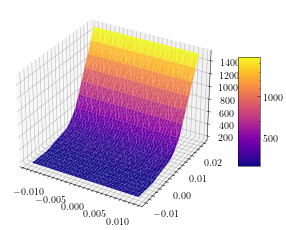


          X         Y            T
0    0.000 -0.013500   170.432083
1    0.000 -0.011658   169.781467
2    0.000 -0.009816   167.891417
3    0.000 -0.007974   165.644285
4    0.000 -0.006132   160.884272
..     ...       ...          ...
775 -0.012  0.017816  1174.850795
776  0.012  0.019658  1353.773282
777 -0.012  0.019658  1353.773282
778  0.012  0.021500  1529.595222
779 -0.012  0.021500  1529.595222

[780 rows x 3 columns]


In [8]:
from exodus_reader import ExodusReader

exodus_reader = ExodusReader('monoblock_out.e')
pos, temps = exodus_reader.generate_side()
exodus_reader.plot_3D(pos[:,0], pos[:,1], temps)
exodus_reader.send_to_csv(pos[:,0], pos[:,1], temps, 'test.csv')

## Step 2 - optimise for a specific number of sensors

Make the following changes to the snippet below:
1. Change the '*test.csv*' to whatever you renamed it to in step 1
2. Change the UniformManager to a SymmetricManager depending on how you want to model the system (do you want to force uniformity in the horizontal direction, or force symmetry?)
3. Change the `RBFModel` to one of `GPModel`, `RBFModel`, `CTModel`, `CSModel`, or `LSModel` depending on which algorithm you want to reconstruct the temperature field 
>* GP is Gaussian Process Regression - only use it for 6 or more sensors as you need more than 3 training datapoints (and up to 3 sensors fail)
>* RBF is RBF interpolation
>* CT is Clough Tocker interpolation - only use it with the symmetric manager
>* CS is Cubic Spline interpolation - only use it with the uniform manager
>* LS is least squares cubic fit - only use it with the uniform manager
4. Change the `num_sensors` to whatever number of sensors you want to optimise for
5. Change the `time_limit` to how long you want to optimise for
6. Change the `'Test: '` to whatever you want to rename the start of the pdf of each Pareto optimal point

Run the code and this will optimise for accuracy and reliability. It will then take ages (maybe 10 on a laptop - but this time depends on how many Pareto optimal points were found) to save all of the pdfs of the Pareto optimal layouts into the results folder. When doing this it will print lots of strings looking like OOXOX. This means that it is drawing the graphs for when the sensors in positions 2 and 4 fail.

In [ ]:
from run_me import *

csv_reader = CSVReader('test.csv')
positions = csv_reader.get_positions()
true_temperatures = csv_reader.get_temperatures()

model_manager = UniformManager(RBFModel, csv_reader)
res = optimise_sensor_layout(model_manager, num_sensors=6, time_limit='00:00:20')
show_optimsiation(res)

for i, setup in enumerate(res.X):
    save_setup(model_manager, positions, true_temperatures, setup, 'Test: '+str(i)+'.pdf')

## What do the results mean?

The Pareto frontier shows the reliability and accuracy of each optimal sensor placement. Note that it is not a perfect curve as there is a certain ammount of randomness in the evaluation of the loss function. 

For each point in the Pareto frontier we produce a pdf report on that sensor setup. On the first page is a bar chart. The inside curve shows what percentage of the time the experiment is successful (the loss is below the `LOSS_LIMIT` of 1e6). The outside curve shows what percentage of the time various sensors fail.

The next pages show all of the possibilities where 3 or less sensors fail, and the field reconstruction. The sensors that fail are shown as a red star instead of a black circle.